# Installing and Importing Necessary Libraries

In [64]:
!pip install textacy

In [2]:
# Import TensorFlow and hub
import tensorflow as tf
import tensorflow_hub as hub

# Plotting
import matplotlib.pyplot as plt

# some important packages
import os
import re
import numpy as np
import pandas as pd
import csv
import json
from collections import defaultdict

# scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# for knowledge graph construction
import spacy
import networkx as nx
from spacy import displacy
import textacy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Saving Title, Abstract & Full Text Path of Articles with Full Text 

In [3]:
df = pd.DataFrame(columns = ['Title', 'Abstract', 'Json Path'])

# open the file
with open('/kaggle/input/CORD-19-research-challenge/metadata.csv') as f_in:
    reader = csv.DictReader(f_in)
    i = 0
    for row in reader:

        if row['pdf_json_files'] or row['pmc_json_files']:
            cord_uid = row['cord_uid']
            title = row['title']
            abstract = row['abstract']
            if row['pmc_json_files']:
                json_path = (row['pmc_json_files'].split('; '))[0]
            elif row['pdf_json_files']:
                json_path = (row['pdf_json_files'].split('; '))[0]
                

            # save for later usage
            df.loc[cord_uid] = [title, abstract, json_path]
            

            if i%100 == 0:
                print(json_path)
                if (i == 1000):
                    break
            i += 1

document_parses/pmc_json/PMC35282.xml.json
document_parses/pmc_json/PMC1939851.xml.json
document_parses/pmc_json/PMC2600245.xml.json
document_parses/pmc_json/PMC2779497.xml.json
document_parses/pmc_json/PMC2894058.xml.json
document_parses/pmc_json/PMC3048347.xml.json
document_parses/pmc_json/PMC3154197.xml.json
document_parses/pmc_json/PMC3245300.xml.json
document_parses/pmc_json/PMC3320380.xml.json
document_parses/pmc_json/PMC3410888.xml.json
document_parses/pmc_json/PMC3522074.xml.json


In [4]:
df = df.dropna()
df.head()

,Title,Abstract,Json Path
ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,document_parses/pmc_json/PMC35282.xml.json
02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,document_parses/pmc_json/PMC59543.xml.json
ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,document_parses/pmc_json/PMC59549.xml.json
2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,document_parses/pmc_json/PMC59574.xml.json
9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,document_parses/pmc_json/PMC59580.xml.json


# Filtering to articles relevant to Genome Analysis

This is done using encoding the paper abstracts into sentence embedding using Universal Sentence Encoder from TensorFlow Hub and running K-Nearest Kneighbors algorithm on the embeddings.

In [5]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(model_url)
print('Model Loaded')

Model Loaded


In [6]:
model(['genome'])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 4.78655286e-02, -6.42847642e-02, -9.15826671e-03,
         1.78563111e-02,  3.78418081e-02, -5.39028347e-02,
         3.79133299e-02,  2.34950781e-02,  3.31154503e-02,
         5.89484873e-04,  8.57106224e-02,  4.16130461e-02,
         5.38943044e-04, -2.82500777e-02,  3.87888029e-02,
        -7.21597672e-02, -8.33567828e-02, -2.26966366e-02,
         4.75704968e-02, -3.24246958e-02, -5.34603186e-02,
         4.53720801e-02,  4.39359769e-02,  7.66607150e-02,
         2.83191726e-02, -3.13636218e-03,  5.49516752e-02,
         3.61459628e-02, -4.24567200e-02,  1.41065018e-02,
         7.45514408e-02,  8.71380791e-02, -5.79004250e-02,
        -4.19201069e-02,  5.12831286e-02,  5.67376539e-02,
        -8.39042813e-02,  7.71590248e-02, -4.74311262e-02,
         3.18903439e-02, -3.32356058e-02, -4.27644290e-02,
         3.66864577e-02, -6.70655519e-02, -1.36605427e-02,
        -2.96186283e-02,  2.09980421e-02, -3.51986848e-02,
      

In [7]:
abstracts = list(df['Abstract'])

In [8]:
abstracts[:5]

['OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (35%) with upper respiratory tract infections, and 2 (5%) with bronchiolitis. Cough (82.5%), fever (75%), and malaise (58.8%) were

In [9]:
abstract_embeddings = model(abstracts)
abstract_embeddings.shape

TensorShape([1001, 512])

Visualizing sentence embeddings after dimensionality reduction in 2d: -

In [10]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(abstract_embeddings)

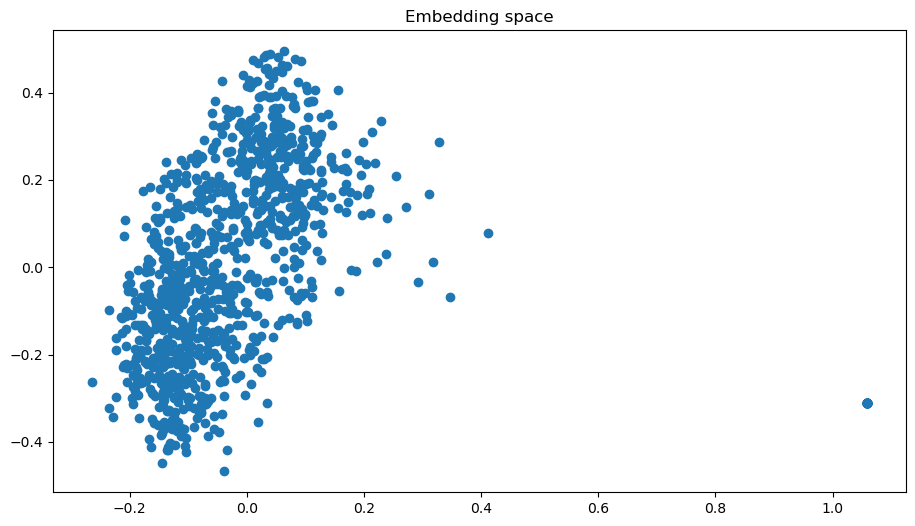

In [11]:
plt.figure(figsize=(11, 6))
plt.title('Embedding space')
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.show()

In [12]:
n = 100
nn = NearestNeighbors(n_neighbors=n)
nn.fit(abstract_embeddings)

NearestNeighbors(n_neighbors=100)

In [13]:
emb = model(['genome'])
neighbors = nn.kneighbors(emb, return_distance=False)[0]

Titles of first 10 out of 1000 filtered articles: -

In [14]:
(df['Title'].iloc[neighbors].tolist())[:10]

['RNA-Seq Based Transcriptional Map of Bovine Respiratory Disease Pathogen “Histophilus somni 2336”',
 'Competition between Influenza A Virus Genome Segments',
 'Discovery and Genomic Characterization of a Novel Bat Sapovirus with Unusual Genomic Features and Phylogenetic Position',
 'Detection and characterization of horizontal transfers in prokaryotes using genomic signature',
 'Comparative analysis of mycobacterium and related actinomycetes yields insight into the evolution of mycobacterium tuberculosis pathogenesis',
 's-RT-MELT for rapid mutation scanning using enzymatic selection and real time DNA-melting: new potential for multiplex genetic analysis',
 'Analysis of synonymous codon usage and evolution of begomoviruses',
 'Inferring viral quasispecies spectra from 454 pyrosequencing reads',
 'Species-specific evolution of immune receptor tyrosine based activation motif-containing CEACAM1-related immune receptors in the dog',
 'Role of RNA helicases in HIV-1 replication']

In [15]:
jsons = df['Json Path'].iloc[neighbors].tolist()

# Extracting paragraphs from Full Text

In [16]:
paragraphs = []

for json_path in jsons:
    with open('/kaggle/input/CORD-19-research-challenge/'+json_path) as f_json:
        full_text_dict = json.load(f_json)
        # grab introduction section from *some* version of the full text
        for paragraph_dict in full_text_dict['body_text']:
            paragraphs.append(paragraph_dict['text'])

In [17]:
len(paragraphs)

3481

In [18]:
paragraphs[:5]

["Systems biology approaches are designed to facilitate the study of complex interactions among genes, proteins, and other genomic elements [1], [2], [3]. In the context of infectious disease, systems biology has the potential to complement reductionist approaches to resolve the complex interactions between host and pathogen that determine disease outcome. However, a prerequisite for systems biology is the description of the system's components. Therefore, genome structural annotation or the identification and demarcation of boundaries of functional elements in a genome (e.g., genes, non-coding RNAs, proteins, and regulatory elements) are critical elements in infectious disease systems biology.",
 'Bovine Respiratory Disease (BRD) costs the cattle industry in the United States as much as $3 billion annually [4], [5]. BRD is the outcome of complex interactions among host, environment, bacterial, and viral pathogens [6]. Histophilus somni, a gram-negative, pleomorphic species, is one of 

# Separating Sentences and filtering to the most relevant sentences

In [62]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(paragraphs[8])
lst_docs = [sent for sent in doc.sents]

i = 1
displacy.render(lst_docs[i], style="dep", options={"distance":100})
displacy.render(lst_docs[i], style="ent")

In [28]:
for tag in lst_docs[2].ents:
    print(tag.text, f"({tag.label_})")

at least two (CARDINAL)


In [21]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
all_lst_docs = []

# Function to extract entities and relationships related to a specific topic
for paragraph in paragraphs:
    doc = nlp(paragraph)
    
    # from text to a list of sentences
    lst_docs = [sent for sent in doc.sents]
    all_lst_docs.extend(lst_docs)

In [22]:
len(all_lst_docs)

20128

In [23]:
all_lst_docs[1000:1010]

[Using a combination of direct isolation of small RNAs, and validation by Northern blotting and 5' and 3' RACE transcript mapping, Arnvig and Young [62] first described nine sRNAs in Mtb.,
 Subsequently, DiChiara et al.,
 [63] describe 34 small RNAs in M. bovis BCG, of which many were conserved in both Mtb and M. smegmatis.,
 To build on these results, we used a combination of comparative genomics, RNA-seq, and experimental validation by Northern blotting to identify additional sRNAs conserved among the Mycobacteria (Methods).,
 Our computational results provide evidence for 50 conserved small RNAs in Mtb that have not been previously reported.,
 It is likely that additional conserved regions are expressed under other diverse conditions.,
 Figure 5a shows the expression and conservation map for one of our predicted RNAs in the GenomeView Browser,
 [64].,
 Table 6 shows a listing of the top 12 candidate RNAs.,
 To verify a subset of these candidate small RNAs, we used Northern blot anal

In [ ]:
sent_embeddings = model(all_lst_docs)
sent_embeddings.shape
emb_2d = pca.fit_transform(sent_embeddings)

n = 2500
nn = NearestNeighbors(n_neighbors=n)
nn.fit(abstract_embeddings)

emb = model(['genome'])
neighbors = nn.kneighbors(emb, return_distance=False)[0]

In [ ]:
genome_sents = all_lst_docs[neighbors]
genome_sents[:10]

# Constructing Knowledge Graph using NetworkX

In [29]:

## extract entities and relations
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(all_lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))  
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)


## create dataframe
dtf = pd.DataFrame(dic)

## example
dtf[dtf["id"]==i]

,id,text,entity,relation,object
1,1,"In the context of infectious disease, systems ...",systems_biology,has,potential


In [30]:
dtf.head()

,id,text,entity,relation,object
0,0,Systems biology approaches are designed to fac...,biology_approaches,are_designed,to_facilitate_the_study_of_complex_interaction...
1,1,"In the context of infectious disease, systems ...",systems_biology,has,potential
2,4,Bovine Respiratory Disease (BRD) costs the cat...,Bovine_Respiratory_Disease,costs,cattle_industry_3_billion_4_5
3,9,"H. somni causes bovine infertility, abortion, ...",H._somni,causes,infertility_abortion_septicemia_arthritis_myoc...
4,11,"H. somni strain 2336, the serotype used in thi...",somni_strain_serotype,has,Mbp_genome_2044


In [35]:
## extract attributes
attribute = "DATE"
dic = {"id":[], "text":[], attribute:[]}

for n,sentence in enumerate(lst_docs):
    lst = list(textacy.extract.entities(sentence, include_types={attribute}))
    if len(lst) > 0:
        for attr in lst:
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic[attribute].append(str(attr))
    else:
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic[attribute].append(np.nan)

dtf_att = pd.DataFrame(dic)
dtf_att = dtf_att[~dtf_att[attribute].isna()]

## example
dtf_att[dtf_att["id"]==i]

,id,text,DATE


In [51]:
## create full graph
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())

G

In [ ]:
## plot
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()